Exercise: *Train a deep MLP on the MNIST dataset (you can load it using `tf.keras.datasets.mnist.load_data()`). See if you can get over 98% accuracy by manually tuning the hyperparameters.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-02-26 22:02:25.134022: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 22:02:25.161854: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 22:02:25.254863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 22:02:25.254916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 22:02:25.270188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Just like the Fashion MNIST dataset, the MNIST training set contains 60,000 greyscale images, each has 28x28 pixels.

In [3]:
X_train_full.shape

(60000, 28, 28)

Each pixel is also represented as a byte (0 to 255).

In [4]:
X_train_full.dtype

dtype('uint8')

We now slipt the full training set into validation set and a (smaller) training set. We also scale the pixel intensities down to 0-1 range and convert them to floats, by dividing to 255, just like we did for Fashion MNIST in the learning notebook.

In [5]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

Let's plot an image using Matplotlib's `imshow()` function, with a `binary` color map.

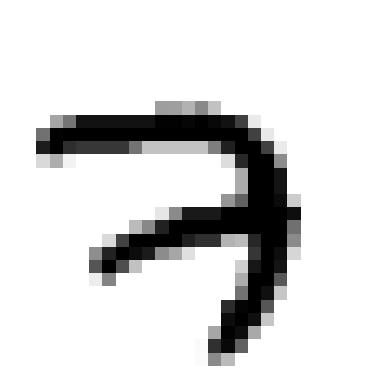

In [6]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

The labels are class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array.

In [7]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images.

In [8]:
X_valid.shape

(5000, 28, 28)

In [9]:
X_test.shape

(10000, 28, 28)

Let's look at some images from the dataset.

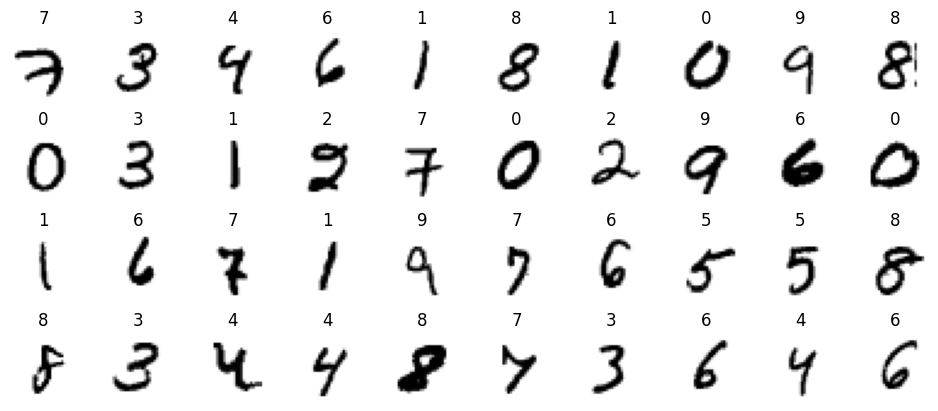

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary")
        plt.axis("off")
        plt.title(y_train[index])
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

Here we build a simple dense network and find its optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration.

In [11]:
K = tf.keras.backend


class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        # You can see the docstring of K.set_value() for more detail
        K.set_value(
            self.model.optimizer.learning_rate,
            self.model.optimizer.learning_rate * self.factor,
        )

In [12]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

We will start with a small learning rate of $10^{-3}$, and grow it by 0.5% at each iteration.

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
exp_lr_cb = ExponentialLearningRate(factor=1.005)

Now, let's train the model for just 1 epoch.

In [15]:
history = model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_data=(X_valid, y_valid),
    callbacks=[exp_lr_cb],
)

1719/1719 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.5913 - val_loss: nan - val_accuracy: 0.0958


We can now plot the loss a function as a function of the learning rate.

Text(0, 0.5, 'Loss')

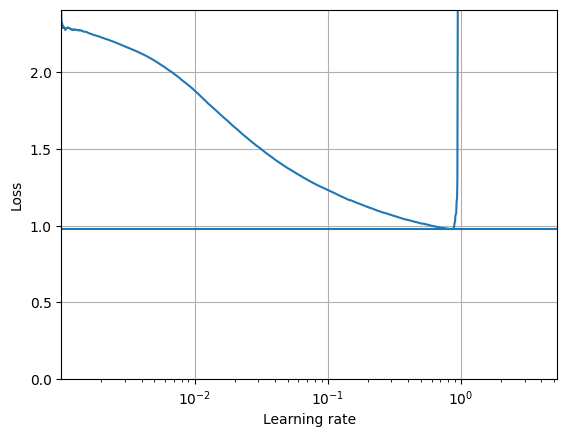

In [16]:
plt.plot(exp_lr_cb.rates, exp_lr_cb.losses)
plt.xscale("log")
plt.hlines(min(exp_lr_cb.losses), min(exp_lr_cb.rates), max(exp_lr_cb.rates))
plt.axis([min(exp_lr_cb.rates), max(exp_lr_cb.rates), 0, exp_lr_cb.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

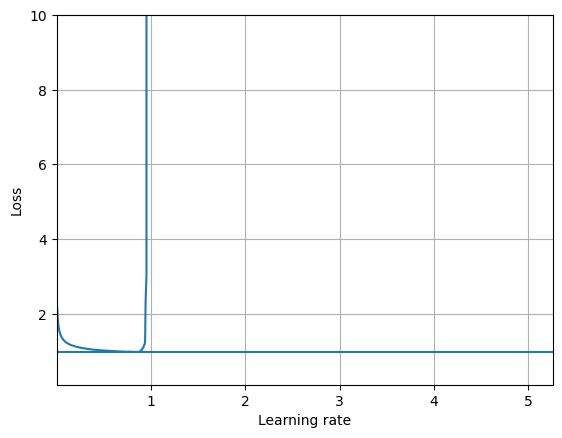

In [17]:
plt.plot(exp_lr_cb.rates, exp_lr_cb.losses)
plt.hlines(min(exp_lr_cb.losses), min(exp_lr_cb.rates), max(exp_lr_cb.rates))
plt.axis([min(exp_lr_cb.rates), max(exp_lr_cb.rates), 0.1, 10])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the rate goes about 1, so we will try using half of that, at 0.5.

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [19]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [21]:
# Remove the logs directory every time rerun this notebook
import shutil

shutil.rmtree("my_exercise_logs", ignore_errors=True)

In [22]:
from pathlib import Path

run_index = 1  # increment this at every run
run_logdir = Path() / "my_exercise_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_exercise_logs/run_001')

In [25]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_exercise_model", save_best_only=True
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],
)

Epoch 1/100
1712/1719 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9921INFO:tensorflow:Assets written to: my_exercise_model/assets


INFO:tensorflow:Assets written to: my_exercise_model/assets


1719/1719 [==============================] - 4s 2ms/step - loss: 0.0301 - accuracy: 0.9921 - val_loss: 0.1572 - val_accuracy: 0.9726
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0286 - accuracy: 0.9919 - val_loss: 0.1856 - val_accuracy: 0.9704
Epoch 3/100
1694/1719 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9949INFO:tensorflow:Assets written to: my_exercise_model/assets


INFO:tensorflow:Assets written to: my_exercise_model/assets


1719/1719 [==============================] - 4s 2ms/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.1153 - val_accuracy: 0.9794
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0137 - accuracy: 0.9960 - val_loss: 0.1381 - val_accuracy: 0.9790
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0186 - accuracy: 0.9949 - val_loss: 0.1612 - val_accuracy: 0.9740
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0197 - accuracy: 0.9948 - val_loss: 0.1590 - val_accuracy: 0.9776
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0242 - accuracy: 0.9938 - val_loss: 0.1331 - val_accuracy: 0.9794
Epoch 8/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.1702 - val_accuracy: 0.9742
Epoch 9/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0188 - accuracy: 0.9953 - val_loss: 0.1598 - val_accuracy: 0.97

In [26]:
# Rollback to best model
model = tf.keras.models.load_model("my_exercise_model")
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.1234 - accuracy: 0.9789


[0.12341801822185516, 0.9789000153541565]

We got nearly 98% accuracy. Finally, let's look at the learning curves using TensorBoard.

In [28]:
%load_ext tensorboard
%tensorboard --logdir=./my_exercise_logs

Launching TensorBoard...